In [ ]:
import os

import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt
from skimage.io import imread
from skimage.transform import resize
import albumentations as A

from unet import *
from unet_utils import *
from visualization import *

from matplotlib import rcParams
rcParams['figure.figsize'] = (15, 4)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
def predict_masks(images, threshold=0.5, num=2):

    image = np.swapaxes(torch.Tensor(np.expand_dims(images[num], axis=0)), 1, 3)

    model.eval()
    with torch.set_grad_enabled(False):
        input = image.to(device, dtype=torch.float)
        output = model(input)
            
    output = output.detach().cpu().numpy()
    output[output >= threshold] = 1.
    output[output <= threshold] = 0.

    image = np.array(image)

    image = np.swapaxes(image, 1, 3)
    output = np.swapaxes(output, 1, 3)

    return image[0], output[0][:, :, 0]
    

def visualization_results(tumor_HR, tumor_LR, tumor_GT, masks, num=12):

    _, mask_HR = predict_masks(tumor_HR, num=num)
    _, mask_LR = predict_masks(tumor_LR, num=num)
    image, mask_GT = predict_masks(tumor_GT, num=num)
    mask = masks[num]

    plt.figure(figsize=(36, 12))
    scenes = [image, mask, mask_LR, mask_HR, mask_GT]
    names = ['image', 'mask', 'mask LR', 'mask HR', 'mask GT']
    scores = [dice_score(mask, mask_LR),
              dice_score(mask, mask_HR),
              dice_score(mask, mask_GT)]

    for i in range(len(scenes)):
        plt.subplot(1, 5, i + 1)
        plt.axis('off')
        if i == 0 or i == 1:
            plt.title(names[i], fontdict={'fontsize': 15})
        else:
            plt.title(names[i] + '   ' + str(round(scores[i - 2], 3)), fontdict={'fontsize': 20})
        plt.imshow(scenes[i])

    plt.show()

## Need functions

In [ ]:
def get_data(input_path, scene, mode='tumor', size=(256, 256)):
    path = os.path.join(input_path, scene)
    images, names = [], []

    for image in sorted(os.listdir(path)):
        names.append(int(image[:-4]))

    names.sort()
    
    for i in range(len(names)):
        images.append(imread(os.path.join(path, str(names[i]) + '.jpg')))

    if mode == 'tumor':
        out = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
    else:
        out = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in images]

    print(f'loaded {len(out)} {scene}')
    return np.array(out, np.float32)

## Getting and Preprocessing Data

In [ ]:
input_path = '/content/gdrive/My Drive/ВКР/ВКР (4 курс)/datasets/'

tumor = get_data(input_path, 'tumor_train')
masks = get_data(input_path, 'masks_train', mode='masks')

loaded 1029 tumor_train
loaded 1029 masks_train


In [ ]:
print(f'we have {len(tumor)} tumor images and {len(masks)} their masks')

we have 1029 tumor images and 1029 their masks


## Augmentation

In [ ]:
transform = A.Compose([A.HorizontalFlip(p=0.5),
                       A.RandomBrightnessContrast(p=0.8),
                       A.Rotate(limit=(-90, 90)),
                       A.VerticalFlip(p=0.5),
                       A.ChannelShuffle(),
                       A.RandomRotate90()])

In [ ]:
aug_tumor, aug_masks = [], []

for i in range(len(tumor)):
    transformed = transform(image=tumor[i], mask=masks[i])
    aug_tumor.append(transformed['image'])
    aug_masks.append(transformed['mask'])

In [ ]:
tumor = np.concatenate((tumor, aug_tumor), axis=0)
masks = np.concatenate((masks, aug_masks), axis=0)

In [ ]:
print(f'after augmentation we have {len(tumor)} images and {len(masks)} their masks')

after augmentation we have 2058 images and 2058 their masks


In [ ]:
del aug_tumor, aug_masks

## Data Visualization

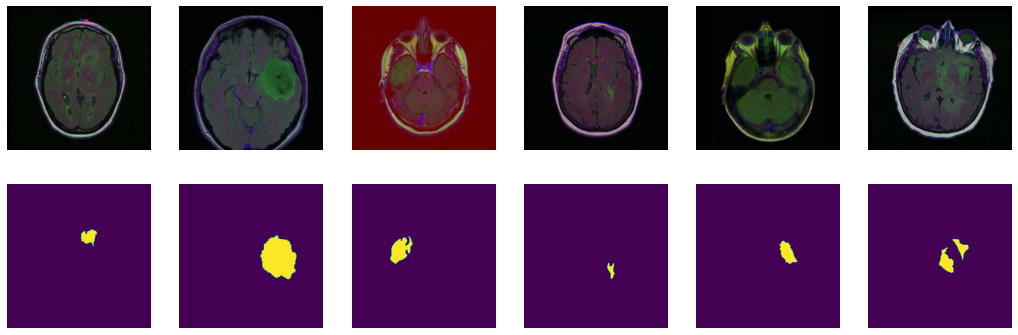

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(0, 6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(tumor[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(masks[i])
plt.show();

## Getting Dataloaders

In [ ]:
train_data, val_data, train_labels, val_labels = train_test_split(tumor, masks, test_size=0.2, shuffle=True)

In [ ]:
data_tr = DataLoader(list(zip(np.rollaxis(train_data, 3, 1), np.expand_dims(train_labels, 1))), batch_size=16, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(val_data, 3, 1), np.expand_dims(val_labels, 1))), batch_size=16, shuffle=True)

In [ ]:
dataset_sizes = {'train': len(train_data), 'val': len(val_data)}

In [ ]:
del tumor, masks, train_data, train_labels, val_data, val_labels

## Model Training

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

In [ ]:
model = UNet(out_channels=1).to(device, dtype=torch.float)

In [ ]:
epochs = 200

criterion = DiceLoss(1e-12)
metric = DiceScore(1e-12)
optimizer = optim.AdamW(model.parameters(), weight_decay=1e-5, amsgrad=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=120, gamma=0.2)

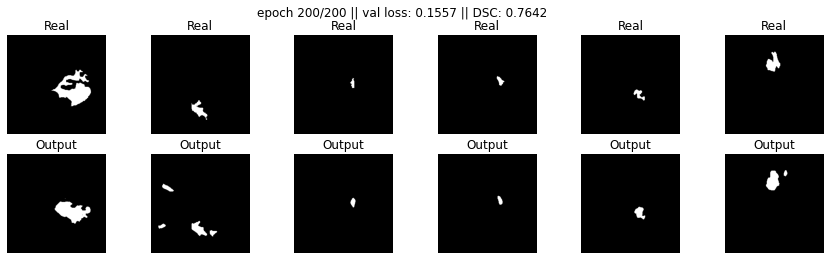

training complete in 293m 2s
best val DSC: 0.772058


In [ ]:
output = train(device, model, data_tr, data_val, dataset_sizes,
               criterion, optimizer, scheduler, metric, num_epochs=epochs)

model = output['model']
history_loss = output['history_loss']
history_metric = output['history_metric']

torch.save(model.state_dict(), '/content/gdrive/My Drive/ВКР/ВКР (4 курс)/datasets/test_models/unet.torch')

In [ ]:
del data_tr, data_val

## Model Evaluation

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(out_channels=1).to(device)
model.load_state_dict(torch.load('/content/gdrive/My Drive/ВКР/ВКР (4 курс)/datasets/test_models/unet.torch'))

<All keys matched successfully>

In [ ]:
input_path = '/content/gdrive/My Drive/ВКР/ВКР (4 курс)/datasets/test_models/gan'
tumor_HR = get_data(input_path, scene='tumor_HR')
tumor_LR = get_data(input_path, scene='tumor_LR')
tumor_GT = get_data(input_path, scene='tumor_GT')

input_path = '/content/gdrive/My Drive/ВКР/ВКР (4 курс)/datasets'
masks = get_data(input_path, scene='masks_test', mode='mask')

dataset_size = len(masks)

loaded 344 tumor_HR
loaded 344 tumor_LR
loaded 344 tumor_GT
loaded 344 masks_test


In [ ]:
tumor_HR_dataloader = DataLoader(list(zip(np.rollaxis(tumor_HR, 3, 1), np.expand_dims(masks, 1))), batch_size=16, shuffle=True)
tumor_LR_dataloader = DataLoader(list(zip(np.rollaxis(tumor_LR, 3, 1), np.expand_dims(masks, 1))), batch_size=16, shuffle=True)
tumor_GT_dataloader = DataLoader(list(zip(np.rollaxis(tumor_GT, 3, 1), np.expand_dims(masks, 1))), batch_size=16, shuffle=True)

In [ ]:
score_model(model, dice_score, tumor_LR_dataloader, dataset_size, mode='LR')
score_model(model, dice_score, tumor_HR_dataloader, dataset_size, mode='HR')
score_model(model, dice_score, tumor_GT_dataloader, dataset_size, mode='GT')

score on LR images = 0.787
score on HR images = 0.814
score on GT images = 0.899


## Results visualization

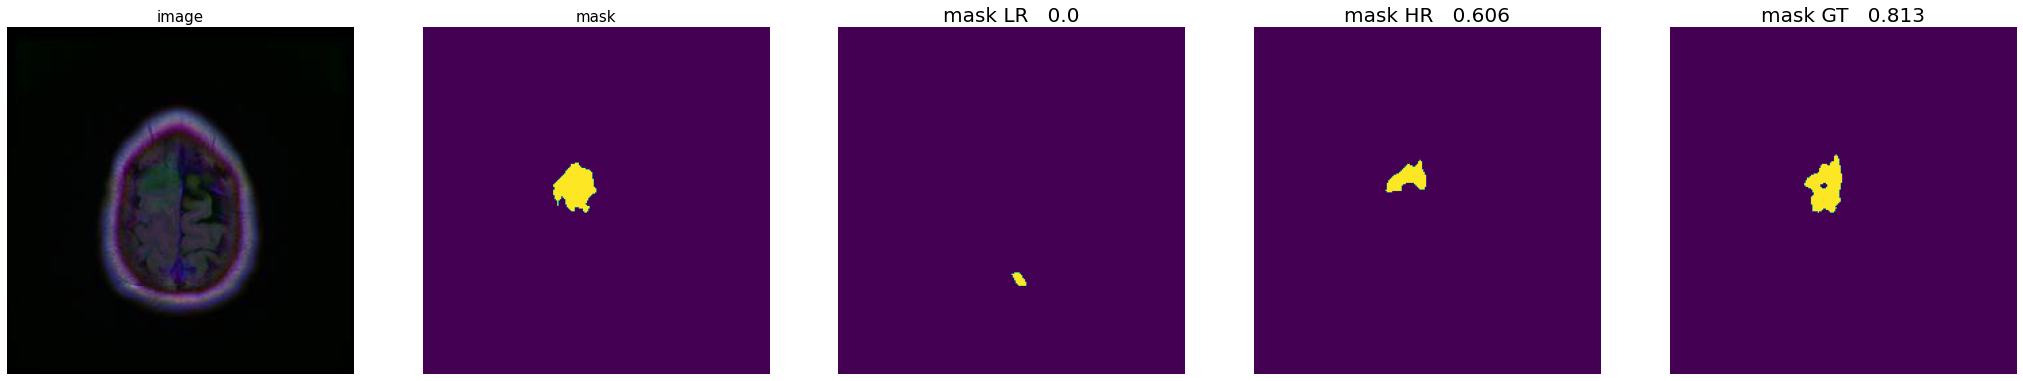

In [ ]:
visualization_results(tumor_HR, tumor_LR, tumor_GT, masks, num=87)

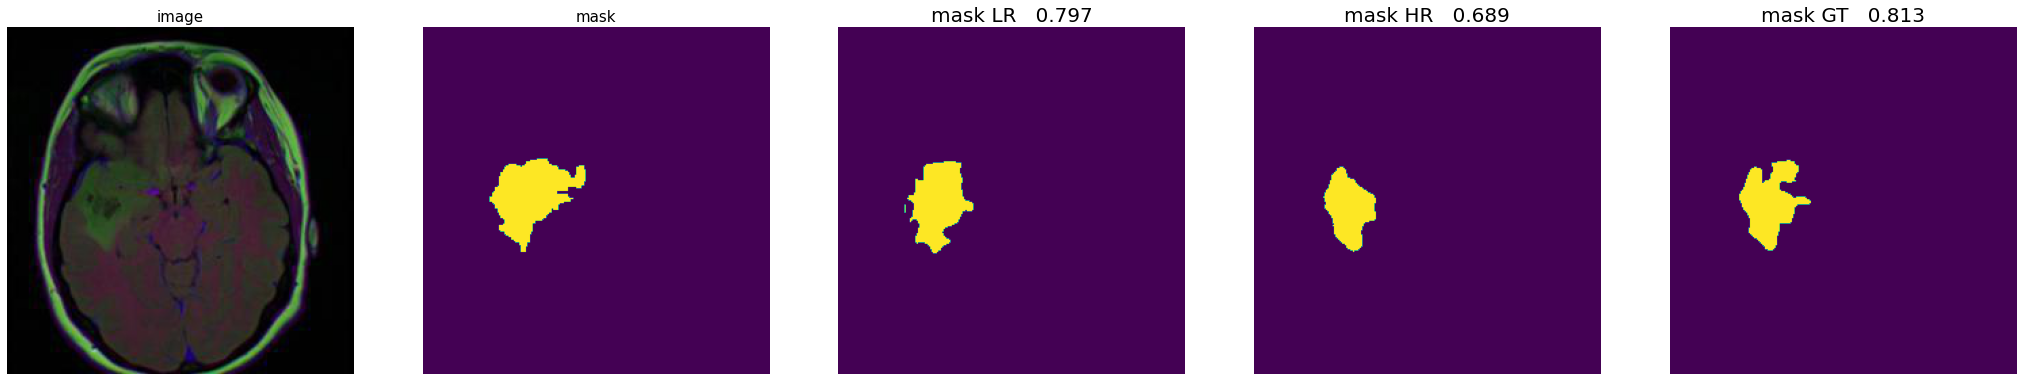

In [ ]:
visualization_results(tumor_HR, tumor_LR, tumor_GT, masks, num=90)

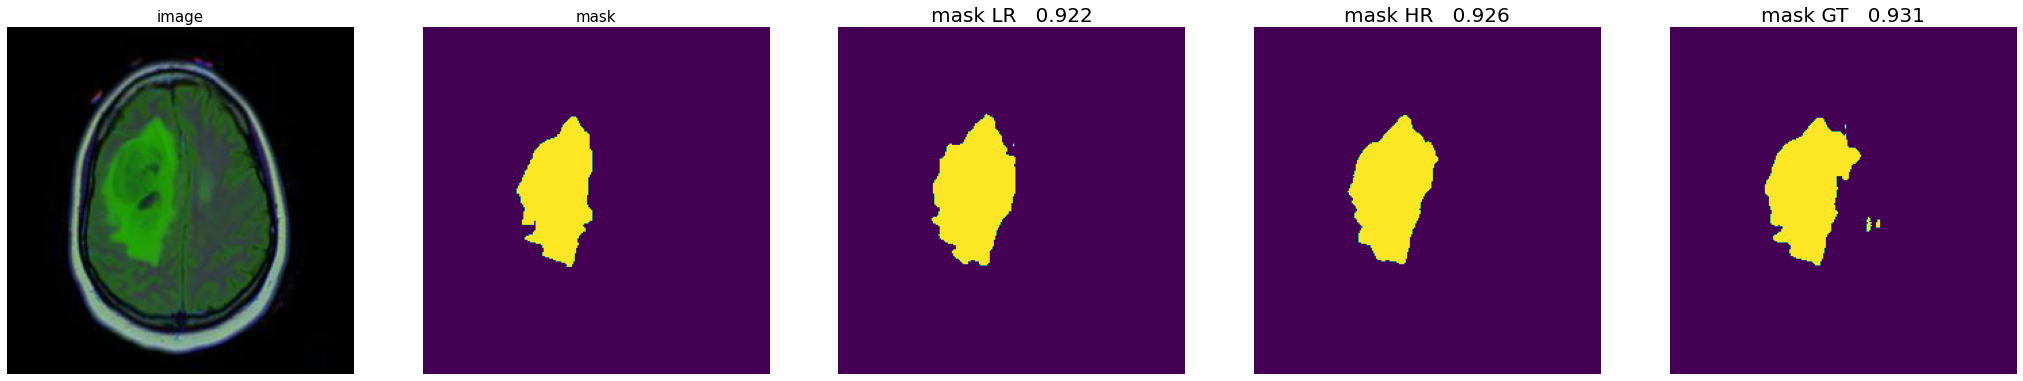

In [ ]:
visualization_results(tumor_HR, tumor_LR, tumor_GT, masks, num=54)

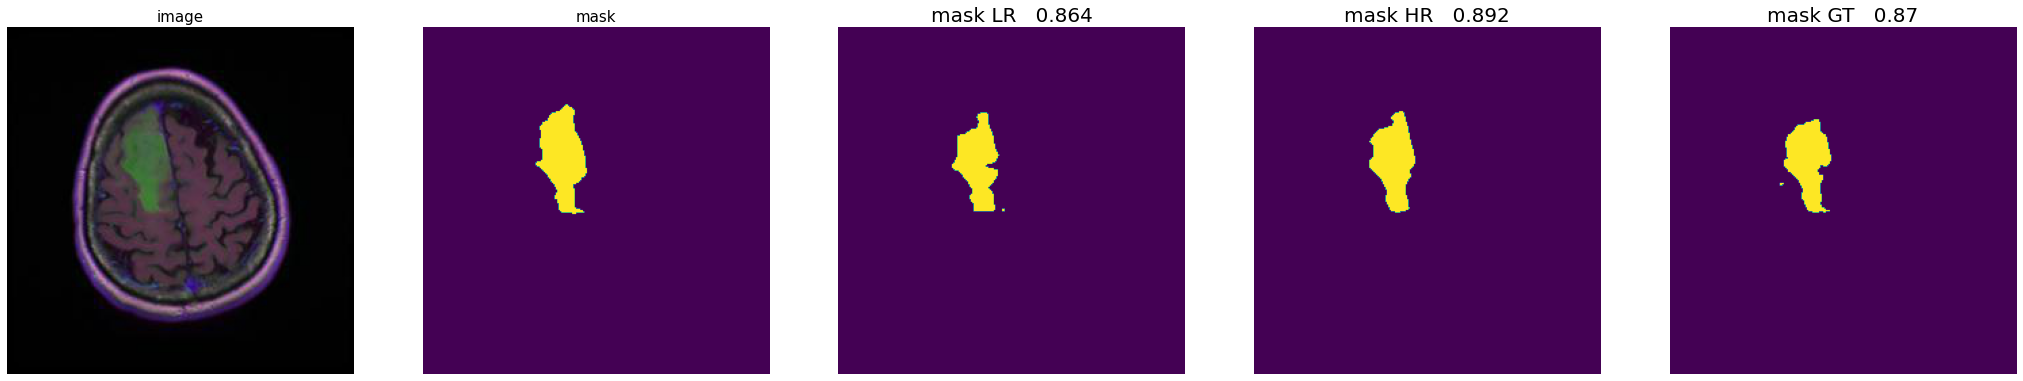

In [ ]:
visualization_results(tumor_HR, tumor_LR, tumor_GT, masks, num=343)